In [1]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
total= pd.read_csv('abril2020junto.csv',sep=',',encoding='utf-8')

In [3]:
def quitar_worldp(df):
   dataset= df[df['Partner']=='World'].index
   return df.drop(dataset)


def quitar_worldr(df):
   dataset= df[df['Reporter']=='World'].index
   return df.drop(dataset)

def crear_grafo_di(df):
    return nx.from_pandas_edgelist(df,'Reporter','Partner','Weight',nx.DiGraph())



def numero_lineas(g):
    return g.number_of_edges()
def numero_nodos(g):
    return g.number_of_nodes()

from networkx import NetworkXError

def _reciprocity_iter(G, nodes):
    """Return an iterator of (node, reciprocity)."""
    n = G.nbunch_iter(nodes)
    for node in n:
        pred = set(G.predecessors(node))
        succ = set(G.successors(node))
        overlap = pred & succ
        n_total = len(pred) + len(succ)

        # Reciprocity is not defined for isolated nodes.
        # Return None.
        if n_total == 0:
            yield (node, None)
        else:
            reciprocity = 2.0 * float(len(overlap)) / float(n_total)
            yield (node, reciprocity)


#[docs]
#@not_implemented_for("undirected", "multigraph")
def overall_reciprocity(G):
    """Compute the reciprocity for the whole graph.

    See the doc of reciprocity for the definition.

    Parameters
    ----------
    G : graph
       A networkx graph

    """
    n_all_edge = G.number_of_edges()
    n_overlap_edge = (n_all_edge - G.to_undirected().number_of_edges()) * 2

    if n_all_edge == 0:
        raise NetworkXError("Not defined for empty graphs")

    return float(n_overlap_edge) / float(n_all_edge)

#__all__ = ["reciprocity", "overall_reciprocity"]


def reciprocity(G, nodes=None):
   
    # If `nodes` is not specified, calculate the reciprocity of the graph.
    if nodes is None:
        return overall_reciprocity(G)

    # If `nodes` represents a single node in the graph, return only its
    # reciprocity.
    if nodes in G:
        reciprocity = next(_reciprocity_iter(G, nodes))[1]
        if reciprocity is None:
            raise NetworkXError("Not defined for isolated nodes.")
        else:
            return reciprocity
            # Otherwise, `nodes` represents an iterable of nodes, so return a
    # dictionary mapping node to its reciprocity.
    return dict(_reciprocity_iter(G, nodes))
        





def _directed_weighted_triangles_and_degree_iter(G, nodes=None, weight="weight"):
  
    import numpy as np

    if weight is None or G.number_of_edges() == 0:
        max_weight = 1
    else:
        max_weight = max(d.get(weight, 1) for u, v, d in G.edges(data=True))

    nodes_nbrs = ((n, G._pred[n], G._succ[n]) for n in G.nbunch_iter(nodes))

    def wt(u, v):
        return G[u][v].get(weight, 1) / max_weight

    for i, preds, succs in nodes_nbrs:
        ipreds = set(preds) - {i}
        isuccs = set(succs) - {i}

        directed_triangles = 0
        for j in ipreds:
            jpreds = set(G._pred[j]) - {j}
            jsuccs = set(G._succ[j]) - {j}
            directed_triangles += sum(
                np.cbrt([(wt(j, i) * wt(k, i) * wt(k, j)) for k in ipreds & jpreds])
            )
            directed_triangles += sum(
                np.cbrt([(wt(j, i) * wt(k, i) * wt(j, k)) for k in ipreds & jsuccs])
            )
            directed_triangles += sum(
                np.cbrt([(wt(j, i) * wt(i, k) * wt(k, j)) for k in isuccs & jpreds])
            )
            directed_triangles += sum(
                np.cbrt([(wt(j, i) * wt(i, k) * wt(j, k)) for k in isuccs & jsuccs])
            )

        for j in isuccs:
            jpreds = set(G._pred[j]) - {j}
            jsuccs = set(G._succ[j]) - {j}
            directed_triangles += sum(
                np.cbrt([(wt(i, j) * wt(k, i) * wt(k, j)) for k in ipreds & jpreds])
            )
            directed_triangles += sum(
                np.cbrt([(wt(i, j) * wt(k, i) * wt(j, k)) for k in ipreds & jsuccs])
            )
            directed_triangles += sum(
                np.cbrt([(wt(i, j) * wt(i, k) * wt(k, j)) for k in isuccs & jpreds])
            )
            directed_triangles += sum(
                np.cbrt([(wt(i, j) * wt(i, k) * wt(j, k)) for k in isuccs & jsuccs])
            )

        dtotal = len(ipreds) + len(isuccs)
        dbidirectional = len(ipreds & isuccs)
        yield (i, dtotal, dbidirectional, directed_triangles)

def transitivity(G):
    
    triangles_contri = [
        (t, d * (d - 1)) for v, d, t, _ in _directed_weighted_triangles_and_degree_iter(G)
    ]
    # If the graph is empty
    if len(triangles_contri) == 0:
        return 0
    triangles, contri = map(sum, zip(*triangles_contri))
    return 0 if triangles == 0 else triangles / contri
def density(G):
 
    n = G.number_of_nodes()
    m = G.number_of_edges()
    d = m / (n * (n - 1))
    return d

In [4]:
total= quitar_worldp(total)

In [5]:
total= quitar_worldr(total)

In [6]:
textiles = pd.read_csv('2020abriltextiles.csv',sep=',',encoding='utf-8')
textiles = quitar_worldp(textiles)
textiles= quitar_worldr(textiles)

In [7]:
vehiculos = pd.read_csv('2020abrilvehiculos.csv',sep=',',encoding='utf-8')
vehiculos = quitar_worldp(vehiculos)
vehiculos= quitar_worldr(vehiculos)

In [8]:
materia = pd.read_csv('2020abrilmateria.csv',sep=',',encoding='utf-8')
materia = quitar_worldp(materia)
materia = quitar_worldr(materia)

In [9]:
materia

,Unnamed: 0,Reporter,Partner,Trade Value (US$),expor,TradeValue,Weight,Type
0,0,EU-28,Rwanda,42118.0,NaN,42118.0,42118.0,Directed
1,1,EU-28,Rwanda,112740.0,NaN,112740.0,112740.0,Directed
2,2,EU-28,Rwanda,62825.0,NaN,62825.0,62825.0,Directed
3,3,EU-28,Rwanda,859.0,NaN,859.0,859.0,Directed
4,4,EU-28,Rwanda,1521.0,NaN,1521.0,1521.0,Directed
...,...,...,...,...,...,...,...,...
425868,425868,Israel,Serbia,NaN,602755.0,602755.0,602755.0,Directed
425869,425869,Israel,Serbia,NaN,214818.0,214818.0,214818.0,Directed
425870,425870,Montenegro,Serbia,NaN,125208.0,125208.0,125208.0,Directed
425871,425871,Montenegro,Serbia,NaN,1679817.0,1679817.0,1679817.0,Directed


In [10]:
def crear_grafos(dataframes):
    grafos = []
    for df in dataframes:
        G = nx.DiGraph()
        for _, row in df.iterrows():
            source = row['Reporter']
            target = row['Partner']
            weight = row['Weight']
            G.add_edge(source, target, weight=weight)
        grafos.append(G)
    return grafos

In [11]:
datasets= [total, vehiculos, textiles, materia]
datasets

[       Unnamed: 0          Reporter        Partner  Trade Value (US$)  \
 0               0            Uganda          Spain          1356732.0   
 1               1            Uganda  Rep. of Korea          3047408.0   
 2               2            Uganda          India         54821300.0   
 3               3            Uganda          Italy          4878253.0   
 4               4            Uganda         Greece           215985.0   
 ...           ...               ...            ...                ...   
 17938       17938     New Caledonia       Malaysia                NaN   
 17939       17939           Vanuatu       Malaysia                NaN   
 17940       17940  Papua New Guinea       Malaysia                NaN   
 17941       17941          Kiribati       Malaysia                NaN   
 17942       17942             China       Malaysia                NaN   
 
               expor    TradeValue        Weight      Type  
 0      5.320466e+06  3.338599e+06  3.338599e+06 

In [12]:
total

,Unnamed: 0,Reporter,Partner,Trade Value (US$),expor,TradeValue,Weight,Type
0,0,Uganda,Spain,1356732.0,5.320466e+06,3.338599e+06,3.338599e+06,Directed
1,1,Uganda,Rep. of Korea,3047408.0,NaN,3.047408e+06,3.047408e+06,Directed
2,2,Uganda,India,54821300.0,2.734912e+07,4.108521e+07,4.108521e+07,Directed
3,3,Uganda,Italy,4878253.0,1.635536e+06,3.256894e+06,3.256894e+06,Directed
4,4,Uganda,Greece,215985.0,6.851840e+05,4.505845e+05,4.505845e+05,Directed
...,...,...,...,...,...,...,...,...
17938,17938,New Caledonia,Malaysia,NaN,7.906177e+06,7.906177e+06,7.906177e+06,Directed
17939,17939,Vanuatu,Malaysia,NaN,1.480420e+05,1.480420e+05,1.480420e+05,Directed
17940,17940,Papua New Guinea,Malaysia,NaN,1.464429e+07,1.464429e+07,1.464429e+07,Directed
17941,17941,Kiribati,Malaysia,NaN,1.380090e+05,1.380090e+05,1.380090e+05,Directed


In [13]:
import networkx as nx

def crear_grafos(dataframes):
    grafos = []

    for df in dataframes:
        G = nx.DiGraph()
        for _, row in df.iterrows():
            source = row['Reporter']
            target = row['Partner']
            weight = row['Weight']  # Suponiendo que 'Peso' es la columna con los pesos
            G.add_edge(source, target, weight=weight)
        grafos.append(G)

    return grafos

# Ejemplo de uso
grafos = crear_grafos(datasets)


In [14]:
import networkx as nx

def get_node_degrees(grafos):
    node_degrees_list = []
    degree_distributions = []

    for graph in datasets:
        # Calculate the degrees of nodes in the graph
        degrees = dict(graph.degree())
        node_degrees = list(degrees.values())
        node_degrees_list.append(node_degrees)

        # Calculate the degree distribution of the graph
        degree_distribution = nx.degree_histogram(graph)
        degree_distributions.append(degree_distribution)

    return node_degrees_list, degree_distributions

# Example usage:



In [15]:
import networkx as nx

def crear_grafos(dataframes):
    grafos = []

    for df in dataframes:
        G = nx.DiGraph()
        for _, row in df.iterrows():
            source = row['Reporter']
            target = row['Partner']
            weight = row['Weight']  # Suponiendo que 'Weight' es la columna con los pesos
            G.add_edge(source, target, weight=weight)
        grafos.append(G)

    return grafos

# Ejemplo de uso
grafos = crear_grafos(datasets)

# Obtener una lista con los grados de cada nodo para cada grafo
grados_por_grafo = [grafo.degree() for grafo in grafos]

# Obtener las distribuciones de grado de cada grafo
distribuciones_grado_por_grafo = [nx.degree_histogram(grafo) for grafo in grafos]


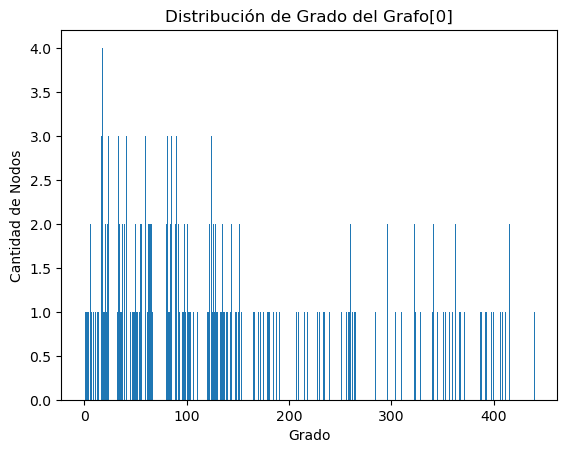

In [16]:
import matplotlib.pyplot as plt

# Obtener la distribución de grado del primer grafo en la lista
distribucion_grado_grafo0 = distribuciones_grado_por_grafo[0]

# Crear una lista de grados (el índice representa el grado)
grados = list(range(len(distribucion_grado_grafo0)))

# Graficar la distribución de grado
plt.bar(grados, distribucion_grado_grafo0)
plt.xlabel('Grado')
plt.ylabel('Cantidad de Nodos')
plt.title('Distribución de Grado del Grafo[0]')
plt.show()


In [17]:
grados_por_grafo

[DiDegreeView({'Uganda': 205, 'Spain': 409, 'Rep. of Korea': 162, 'India': 375, 'Italy': 372, 'Greece': 329, 'Iran': 125, 'Cuba': 101, 'China': 170, 'Gambia': 112, 'Australia': 367, 'Belgium': 388, 'Japan': 392, 'Saint Vincent and the Grenadines': 56, 'South Africa': 353, 'Rwanda': 139, 'Turkey': 387, 'Dem.Rep. of the Congo': 175, 'Niger': 75, 'Papua New Guinea': 70, 'Thailand': 155, 'Russian Federation': 157, 'Burundi': 54, 'France': 166, 'Qatar': 228, 'Ukraine': 340, 'Egypt': 304, 'Romania': 296, 'Kenya': 285, 'Hungary': 293, 'Indonesia': 154, 'Ireland': 360, 'Finland': 345, 'Botswana': 117, 'Nigeria': 135, 'Norway': 324, 'Morocco': 144, 'Lithuania': 287, 'Senegal': 215, 'Lebanon': 127, 'United Arab Emirates': 165, 'Myanmar': 207, 'Belarus': 265, 'Denmark': 357, 'Poland': 400, 'Namibia': 188, 'Burkina Faso': 80, 'Angola': 93, 'Kuwait': 119, 'Mali': 89, 'Other Asia, nes': 158, 'Netherlands': 416, 'Switzerland': 375, 'Slovenia': 323, 'Turks and Caicos Isds': 41, 'Swaziland': 92, 'New Z

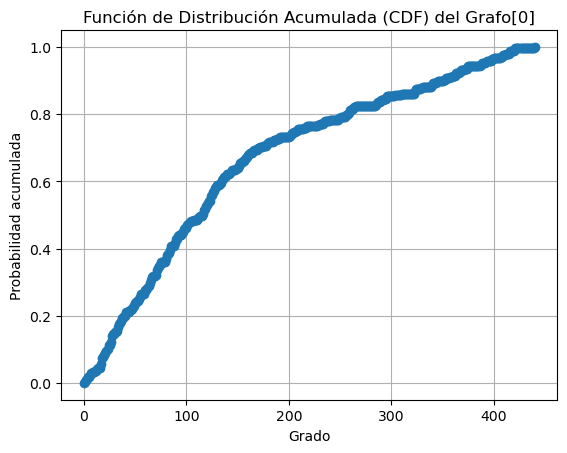

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener la distribución de grado acumulada del primer grafo en la lista
distribucion_grado_grafo0 = distribuciones_grado_por_grafo[0]
grados = np.arange(len(distribucion_grado_grafo0))

# Obtener la CDF acumulando los valores de la distribución de grado
cdf = np.cumsum(distribucion_grado_grafo0)

# Normalizar la CDF para que esté entre 0 y 1
cdf = cdf / cdf[-1]

# Graficar la CDF
plt.plot(grados, cdf, marker='o')
plt.xlabel('Grado')
plt.ylabel('Probabilidad acumulada')
plt.title('Función de Distribución Acumulada (CDF) del Grafo[0]')
plt.grid(True)
plt.show()


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener la distribución de grado del primer grafo en la lista
distribucion_grado_grafo0 = distribuciones_grado_por_grafo[0]
grados = np.arange(len(distribucion_grado_grafo0))

# Normalizar la distribución de grado para obtener la CPD
cpd = distribucion_grado_grafo0 / sum(distribucion_grado_grafo0)

# Obtener la CPD acumulada
cpd_acumulada = np.cumsum(cpd)

# Graficar la CPD acumulada
plt.plot(grados, cpd_acumulada, marker='o')
plt.xlabel('Grado')
plt.ylabel('Probabilidad Acumulada')
plt.title('Distribución de Probabilidad Acumulada (CPD) del Grafo[0]')
plt.grid(True)
plt.show()


TypeError: unsupported operand type(s) for /: 'list' and 'int'

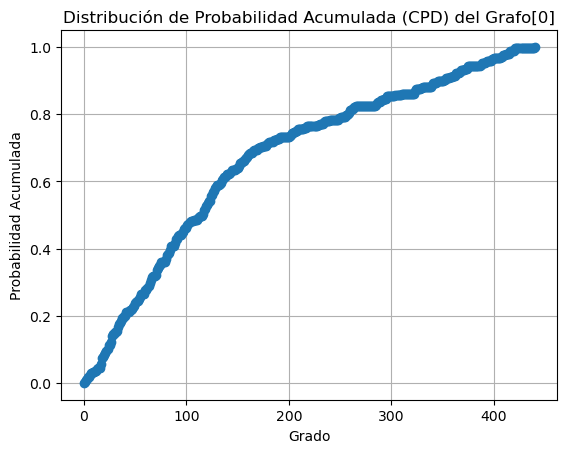

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener la distribución de grado del primer grafo en la lista
distribucion_grado_grafo0 = distribuciones_grado_por_grafo[0]
grados = np.arange(len(distribucion_grado_grafo0))

# Convertir la lista en un array NumPy
distribucion_grado_grafo0 = np.array(distribucion_grado_grafo0)

# Normalizar la distribución de grado para obtener la CPD
cpd = distribucion_grado_grafo0 / sum(distribucion_grado_grafo0)

# Obtener la CPD acumulada
cpd_acumulada = np.cumsum(cpd)

# Graficar la CPD acumulada
plt.plot(grados, cpd_acumulada, marker='o')
plt.xlabel('Grado')
plt.ylabel('Probabilidad Acumulada')
plt.title('Distribución de Probabilidad Acumulada (CPD) del Grafo[0]')
plt.grid(True)
plt.show()


TypeError: float() argument must be a string or a number, not 'dict_values'

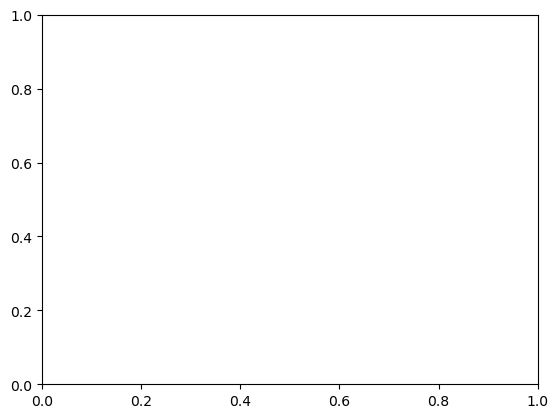

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = dict(graph.degree()).values()

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Graficar la distribución acumulada de grados
    plt.plot(k_values, p_cumulative, "ro-", label="Distribución acumulada de grados")
    plt.yscale("log")
    plt.xlabel("Grado (k)")
    plt.ylabel("Probabilidad acumulada (P(k))")
    plt.title("Distribución acumulada de grados del Grafo[0]")
    plt.legend(loc="upper left")
    plt.show()

# Suponiendo que grafos es la lista de grafos
grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = dict(graph.degree()).values()

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Graficar la distribución acumulada de grados
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0]", fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc="upper left", fontsize=12)
    plt.tight_layout()
    plt.show()

# Suponiendo que grafos es la lista de grafos

#grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Graficar la distribución acumulada de grados
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0]", fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc="upper left", fontsize=12)
    plt.tight_layout()
    plt.show()

# Suponiendo que grafos es la lista de grafos
#grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


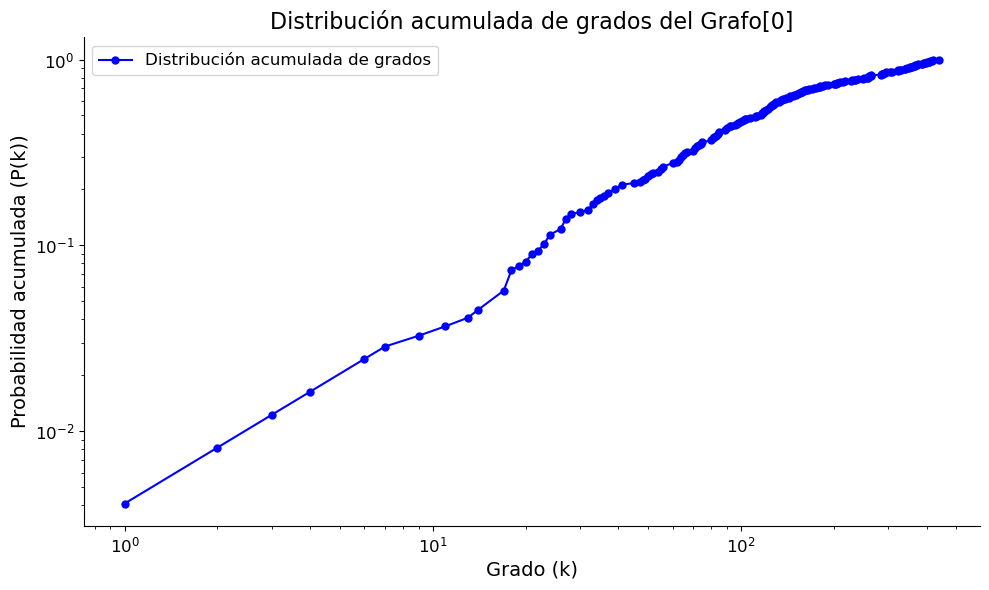

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Graficar la distribución acumulada de grados
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0]", fontsize=16)
    plt.legend(loc="upper left", fontsize=12)

    # Quitar la grilla
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


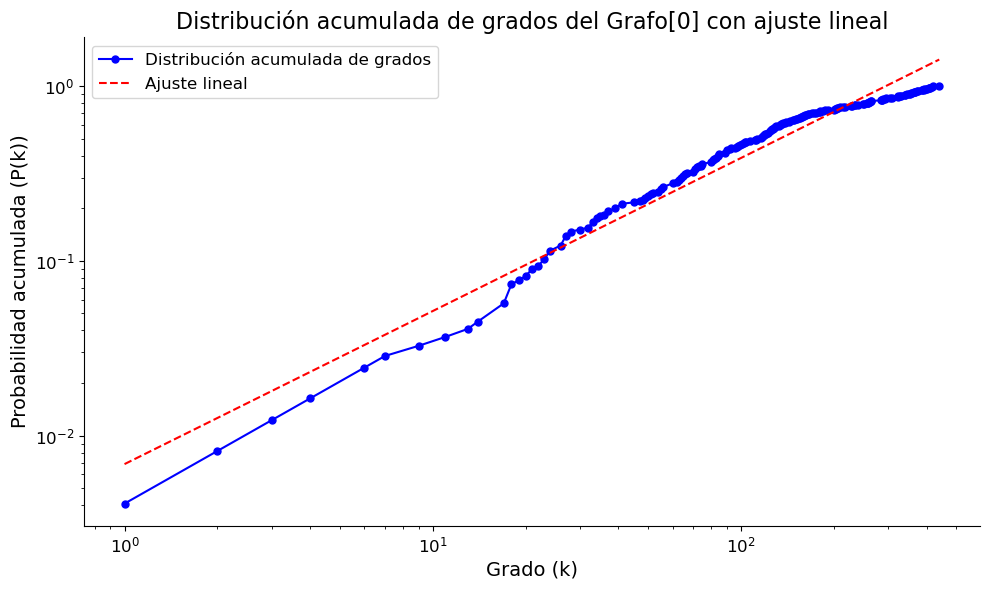

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Ajuste lineal en escala logarítmica
    log_k_values = np.log(k_values)
    log_p_cumulative = np.log(p_cumulative)
    fit_coefficients = np.polyfit(log_k_values, log_p_cumulative, deg=1)
    fit_line = np.polyval(fit_coefficients, log_k_values)

    # Graficar la distribución acumulada de grados y el ajuste lineal
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(np.exp(log_k_values), np.exp(fit_line), "r--", label="Ajuste lineal")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0] con ajuste lineal", fontsize=16)
    plt.legend(loc="upper left", fontsize=12)

    # Quitar la grilla
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con el ajuste lineal del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


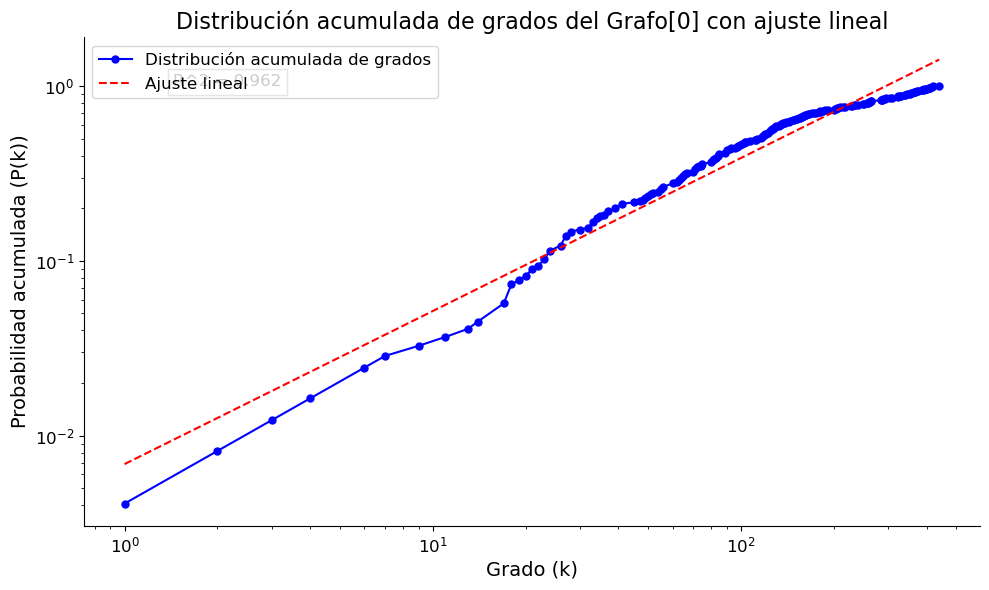

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Ajuste lineal en escala logarítmica
    log_k_values = np.log(k_values)
    log_p_cumulative = np.log(p_cumulative)
    fit_coefficients = np.polyfit(log_k_values, log_p_cumulative, deg=1)
    fit_line = np.polyval(fit_coefficients, log_k_values)

    # Calcular el R^2 del ajuste
    residuals = log_p_cumulative - fit_line
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((log_p_cumulative - np.mean(log_p_cumulative))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Graficar la distribución acumulada de grados y el ajuste lineal
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(np.exp(log_k_values), np.exp(fit_line), "r--", label="Ajuste lineal")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0] con ajuste lineal", fontsize=16)
    plt.legend(loc="upper left", fontsize=12)

    # Quitar la grilla
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    # Imprimir el R^2 en la gráfica
    plt.text(0.1, 0.9, f'R^2 = {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con el ajuste lineal y el R^2 del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


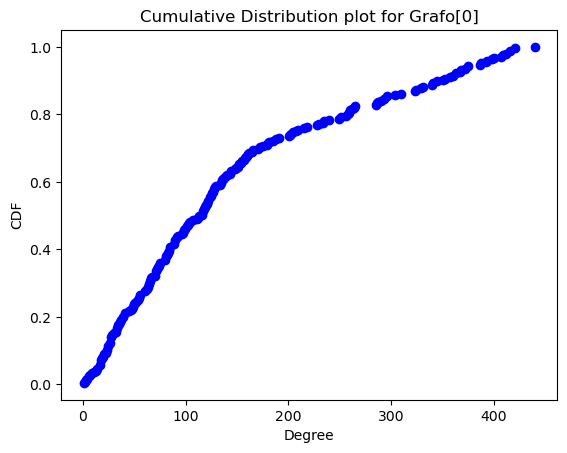

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import collections

def cdf_plot_l(graph, year):
    degree_sequence = sorted([d for n, d in graph.degree()])
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    cs = np.cumsum(cnt) / len(degree_sequence)
    plt.plot(deg, cs, 'bo')
    plt.title(f"Cumulative Distribution plot for {year}")
    
    plt.ylabel("CDF")
    plt.xlabel("Degree")
    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados del primer grafo en la lista
cdf_plot_l(grafos[0], "Grafo[0]")


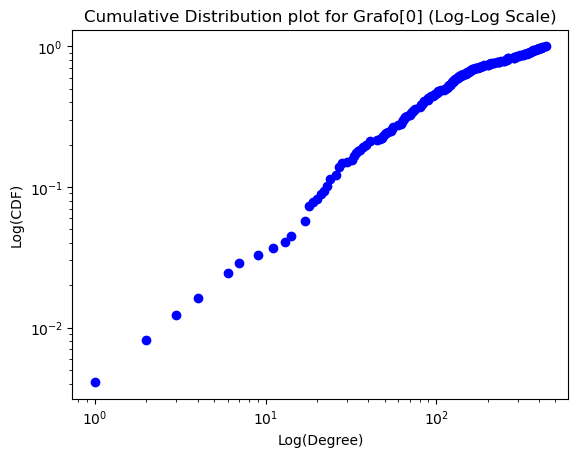

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import collections

def cdf_plot_l_loglog(graph, year):
    degree_sequence = sorted([d for n, d in graph.degree()])
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    cs = np.cumsum(cnt) / len(degree_sequence)
    plt.loglog(deg, cs, 'bo')
    plt.title(f"Cumulative Distribution plot for {year} (Log-Log Scale)")
    
    plt.ylabel("Log(CDF)")
    plt.xlabel("Log(Degree)")
    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados en escala log-log
cdf_plot_l_loglog(grafos[0], "Grafo[0]")


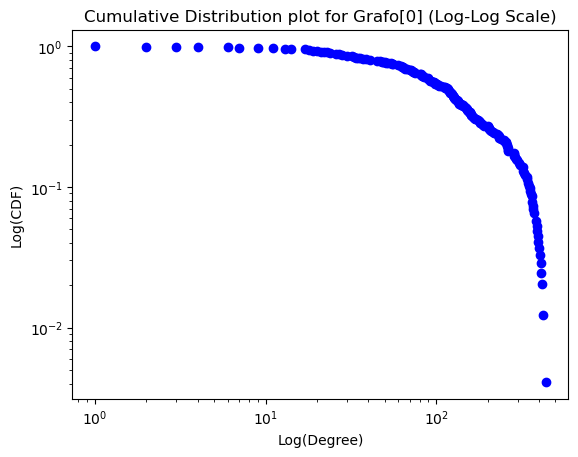

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import collections

def cdf_plot_l_loglog(graph, year):
    degree_sequence = sorted([d for n, d in graph.degree()])
    degreeCount = collections.Counter(degree_sequence)
    num_nodes = len(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    p_k = np.array(cnt) / num_nodes
    p_cumulative = np.cumsum(p_k[::-1])[::-1]  # Invertimos el arreglo para obtener la CDF decreciente
    
    plt.loglog(deg, p_cumulative, 'bo')
    plt.title(f"Cumulative Distribution plot for {year} (Log-Log Scale)")
    
    plt.ylabel("Log(CDF)")
    plt.xlabel("Log(Degree)")
    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados en escala log-log
cdf_plot_l_loglog(grafos[0], "Grafo[0]")


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Invertir los valores de probabilidad acumulada para que la gráfica sea decreciente
    p_cumulative = 1 - p_cumulative

    # Ajuste lineal en escala logarítmica
    log_k_values = np.log(k_values)
    log_p_cumulative = np.log(p_cumulative)
    fit_coefficients = np.polyfit(log_k_values, log_p_cumulative, deg=1)
    fit_line = np.polyval(fit_coefficients, log_k_values)

    # Calcular el R^2 del ajuste
    residuals = log_p_cumulative - fit_line
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((log_p_cumulative - np.mean(log_p_cumulative))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Graficar la distribución acumulada de grados y el ajuste lineal
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(np.exp(log_k_values), np.exp(fit_line), "r--", label="Ajuste lineal")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0] con ajuste lineal", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)

    # Quitar la grilla
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    # Imprimir el R^2 en la gráfica
    plt.text(0.1, 0.9, f'R^2 = {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con el ajuste lineal y el R^2 del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


C:\Users\57320\AppData\Local\Temp\ipykernel_10328\1475269673.py:25: RuntimeWarning: invalid value encountered in log
  log_p_cumulative = np.log(p_cumulative)


LinAlgError: SVD did not converge in Linear Least Squares

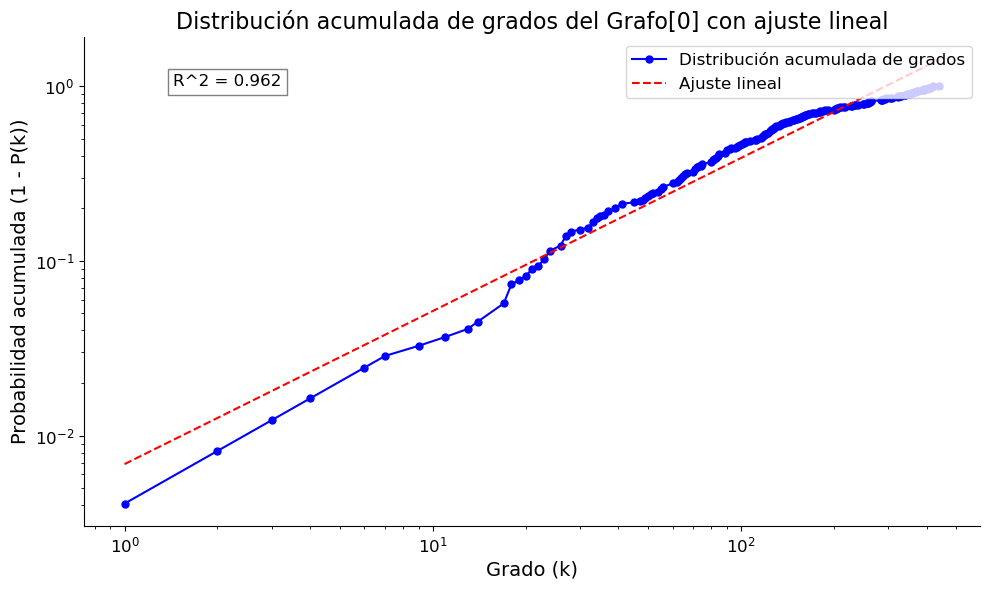

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Eliminar los valores cero y negativos antes de calcular los logaritmos
    valid_indices = p_cumulative > 0
    log_k_values = np.log(k_values[valid_indices])
    log_p_cumulative = np.log(p_cumulative[valid_indices])

    # Ajuste lineal en escala logarítmica
    fit_coefficients = np.polyfit(log_k_values, log_p_cumulative, deg=1)
    fit_line = np.polyval(fit_coefficients, log_k_values)

    # Calcular el R^2 del ajuste
    residuals = log_p_cumulative - fit_line
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((log_p_cumulative - np.mean(log_p_cumulative))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Graficar la distribución acumulada de grados y el ajuste lineal
    plt.figure(figsize=(10, 6))
    plt.plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(np.exp(log_k_values), np.exp(fit_line), "r--", label="Ajuste lineal")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0] con ajuste lineal", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)

    # Quitar la grilla
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    # Imprimir el R^2 en la gráfica
    plt.text(0.1, 0.9, f'R^2 = {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con el ajuste lineal y el R^2 del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


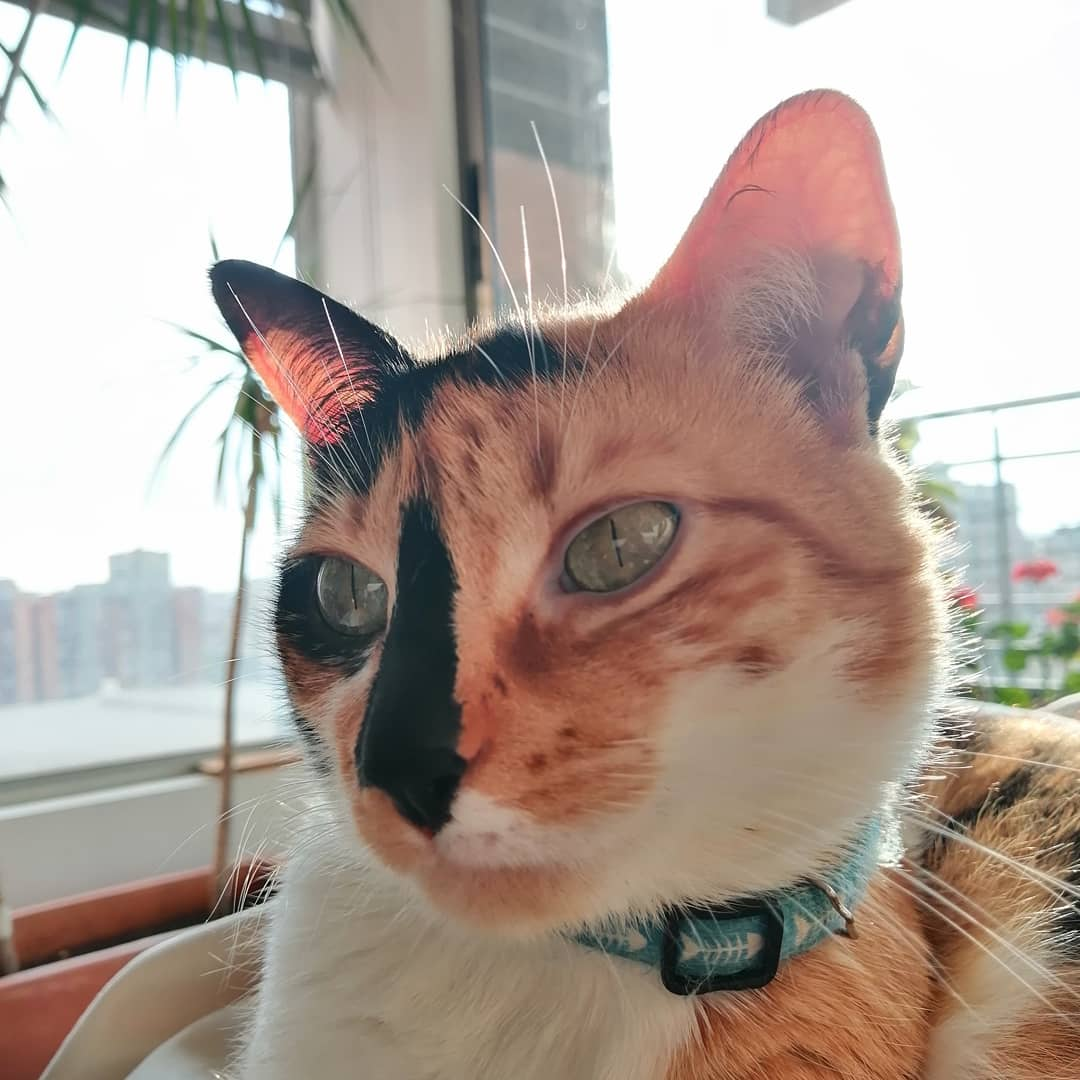

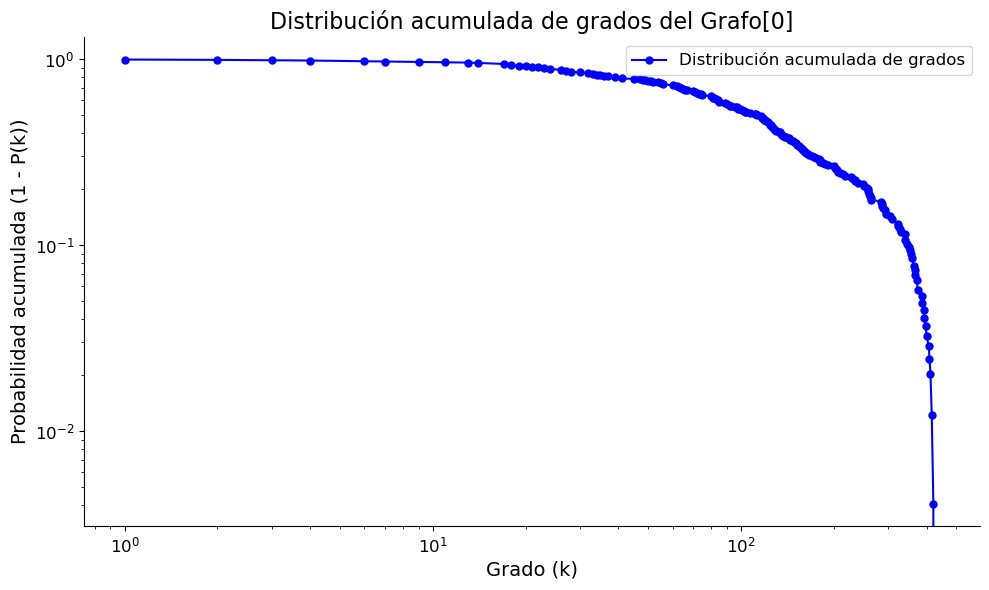

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Graficar la distribución acumulada de grados
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0]", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)

    # Quitar la grilla
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


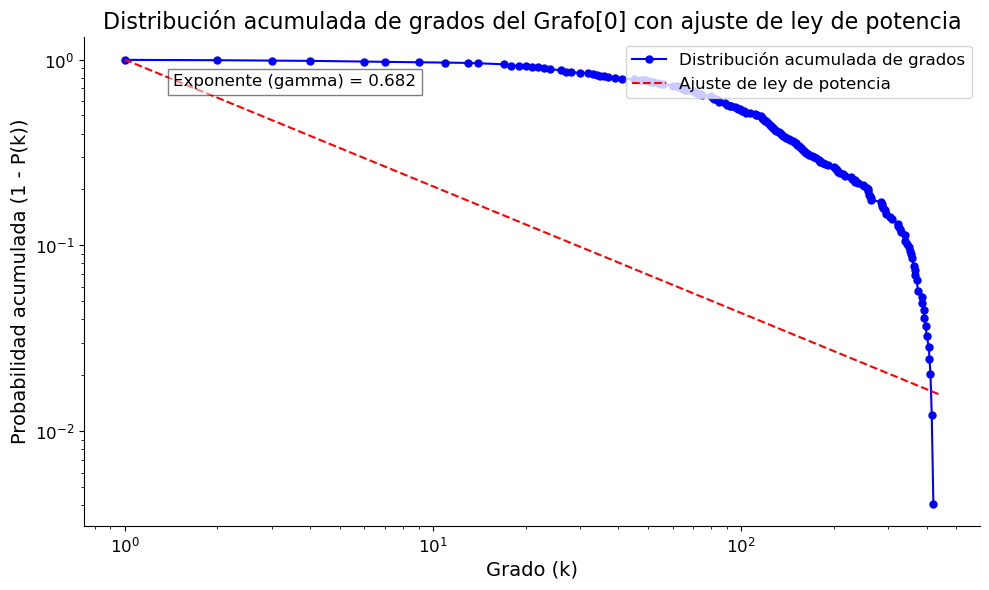

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def power_law_fit(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Eliminar los valores cero y negativos antes de calcular los logaritmos
    valid_indices = p_cumulative > 0
    log_k_values = np.log(k_values[valid_indices])
    log_p_cumulative = np.log(p_cumulative[valid_indices])

    # Ajuste lineal en escala logarítmica
    fit_coefficients = np.polyfit(log_k_values, log_p_cumulative, deg=1)

    # Calcular el exponente de la ley de potencia (gamma)
    gamma = -fit_coefficients[0]

    # Graficar la distribución acumulada de grados y el ajuste lineal
    plt.figure(figsize=(10, 6))
    plt.plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(k_values, k_values**(-gamma), "r--", label="Ajuste de ley de potencia")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0] con ajuste de ley de potencia", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)

    # Quitar la grilla
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    # Imprimir el valor del exponente de la ley de potencia (gamma) en la gráfica
    plt.text(0.1, 0.9, f'Exponente (gamma) = {gamma:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con el ajuste de ley de potencia del primer grafo en la lista
power_law_fit(grafos[0])


In [32]:
total

,Unnamed: 0,Reporter,Partner,Trade Value (US$),expor,TradeValue,Weight,Type
0,0,Uganda,Spain,1356732.0,5.320466e+06,3.338599e+06,3.338599e+06,Directed
1,1,Uganda,Rep. of Korea,3047408.0,NaN,3.047408e+06,3.047408e+06,Directed
2,2,Uganda,India,54821300.0,2.734912e+07,4.108521e+07,4.108521e+07,Directed
3,3,Uganda,Italy,4878253.0,1.635536e+06,3.256894e+06,3.256894e+06,Directed
4,4,Uganda,Greece,215985.0,6.851840e+05,4.505845e+05,4.505845e+05,Directed
...,...,...,...,...,...,...,...,...
17938,17938,New Caledonia,Malaysia,NaN,7.906177e+06,7.906177e+06,7.906177e+06,Directed
17939,17939,Vanuatu,Malaysia,NaN,1.480420e+05,1.480420e+05,1.480420e+05,Directed
17940,17940,Papua New Guinea,Malaysia,NaN,1.464429e+07,1.464429e+07,1.464429e+07,Directed
17941,17941,Kiribati,Malaysia,NaN,1.380090e+05,1.380090e+05,1.380090e+05,Directed


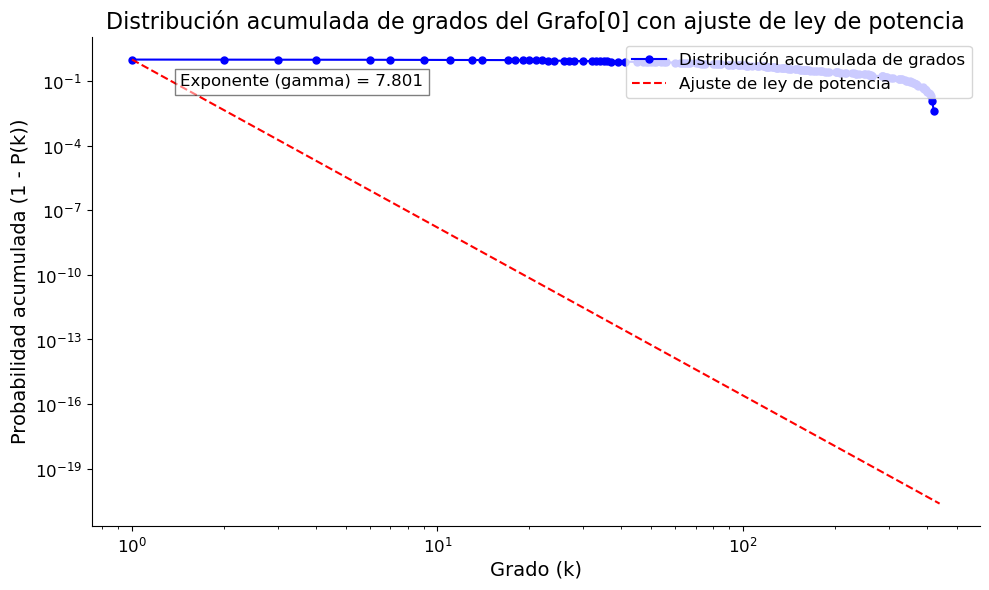

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def power_law_fit(graph, cutoff_value):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Eliminar los valores cero y negativos antes de calcular los logaritmos
    valid_indices = p_cumulative > 0
    log_k_values = np.log(k_values[valid_indices])
    log_p_cumulative = np.log(p_cumulative[valid_indices])

    # Obtener solo los datos después del valor de corte
    cutoff_index = np.argmax(k_values > cutoff_value)
    log_k_values = log_k_values[cutoff_index:]
    log_p_cumulative = log_p_cumulative[cutoff_index:]

    # Ajuste lineal en escala logarítmica
    fit_coefficients = np.polyfit(log_k_values, log_p_cumulative, deg=1)

    # Calcular el exponente de la ley de potencia (gamma)
    gamma = -fit_coefficients[0]

    # Graficar la distribución acumulada de grados y el ajuste lineal
    plt.figure(figsize=(10, 6))
    plt.plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(k_values, k_values**(-gamma), "r--", label="Ajuste de ley de potencia")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados del Grafo[0] con ajuste de ley de potencia", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)

    # Quitar la grilla
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    # Imprimir el valor del exponente de la ley de potencia (gamma) en la gráfica
    plt.text(0.1, 0.9, f'Exponente (gamma) = {gamma:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con el ajuste de ley de potencia del primer grafo en la lista
power_law_fit(grafos[0], cutoff_value=300)


In [34]:
import numpy as np
import matplotlib.pyplot as plt

def power_law_fit(graph, cutoff_value):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Eliminar los valores cero y negativos antes de calcular los logaritmos
    valid_indices = p_cumulative > 0
    log_k_values = np.log(k_values[valid_indices])
    log_p_cumulative = np.log(p_cumulative[valid_indices])

    # Obtener solo los datos después del valor de corte
    cutoff_index = np.argmax(k_values > cutoff_value)
    log_k_values = log_k_values[cutoff_index:]
    log_p_cumulative = log_p_cumulative[cutoff_index:]

    # Ajuste lineal en escala log-lineal
    fit_coefficients_log_linear = np.polyfit(log_k_values, log_p_cumulative, deg=1)

    # Calcular el R^2 del ajuste log-lineal
    fit_line_log_linear = np.polyval(fit_coefficients_log_linear, log_k_values)
    residuals_log_linear = log_p_cumulative - fit_line_log_linear
    ss_res_log_linear = np.sum(residuals_log_linear**2)
    ss_tot_log_linear = np.sum((log_p_cumulative - np.mean(log_p_cumulative))**2)
    r_squared_log_linear = 1 - (ss_res_log_linear / ss_tot_log_linear)

    # Ajuste lineal en escala lineal
    fit_coefficients_linear = np.polyfit(k_values[valid_indices], p_cumulative[valid_indices], deg=1)

    # Calcular el R^2 del ajuste lineal
    fit_line_linear = np.polyval(fit_coefficients_linear, k_values[valid_indices])
    residuals_linear = p_cumulative[valid_indices] - fit_line_linear
    ss_res_linear = np.sum(residuals_linear**2)
    ss_tot_linear = np.sum((p_cumulative[valid_indices] - np.mean(p_cumulative[valid_indices]))**2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)

    # Graficar la distribución acumulada de grados y los ajustes
    plt.figure(figsize=(15, 6))

    # Gráfica en escala log-lineal
    plt.subplot(1, 2, 1)
    plt.plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(np.exp(log_k_values), np.exp(fit_line_log_linear), "r--", label="Ajuste log-lineal")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Ajuste log-lineal de la distribución acumulada de grados", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(False)

    # Gráfica en escala lineal
    plt.subplot(1, 2, 2)
    plt.plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(k_values[valid_indices], fit_line_linear, "r--", label="Ajuste lineal")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Ajuste lineal de la distribución acumulada de grados", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    # Imprimir el R^2 en ambas gráficas
    plt.text(0.1, 0.9, f'R^2 (log-lineal) = {r_squared_log_linear:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.1, 0.9, f'R^2 (lineal) = {r_squared_linear:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con los ajustes log-lineal y lineal del primer grafo en la lista


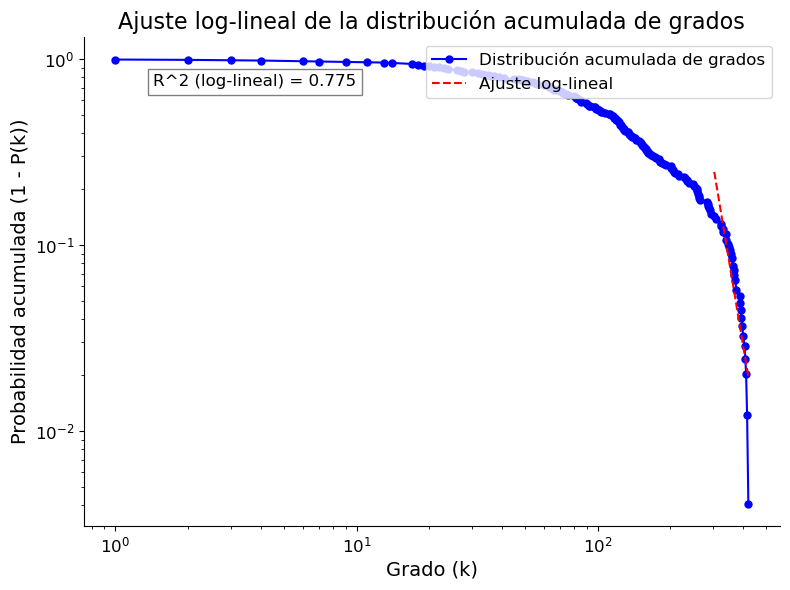

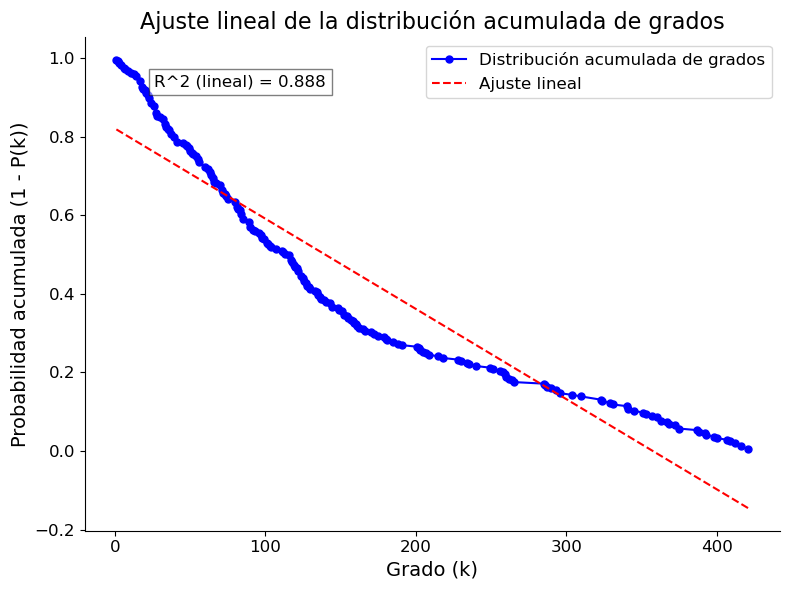

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def power_law_fit(graph, cutoff_value):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Eliminar los valores cero y negativos antes de calcular los logaritmos
    valid_indices = p_cumulative > 0
    log_k_values = np.log(k_values[valid_indices])
    log_p_cumulative = np.log(p_cumulative[valid_indices])

    # Obtener solo los datos después del valor de corte
    cutoff_index = np.argmax(k_values > cutoff_value)
    log_k_values = log_k_values[cutoff_index:]
    log_p_cumulative = log_p_cumulative[cutoff_index:]

    # Ajuste lineal en escala log-lineal
    fit_coefficients_log_linear = np.polyfit(log_k_values, log_p_cumulative, deg=1)

    # Calcular el R^2 del ajuste log-lineal
    fit_line_log_linear = np.polyval(fit_coefficients_log_linear, log_k_values)
    residuals_log_linear = log_p_cumulative - fit_line_log_linear
    ss_res_log_linear = np.sum(residuals_log_linear**2)
    ss_tot_log_linear = np.sum((log_p_cumulative - np.mean(log_p_cumulative))**2)
    r_squared_log_linear = 1 - (ss_res_log_linear / ss_tot_log_linear)

    # Ajuste lineal en escala lineal
    fit_coefficients_linear = np.polyfit(k_values[valid_indices], p_cumulative[valid_indices], deg=1)

    # Calcular el R^2 del ajuste lineal
    fit_line_linear = np.polyval(fit_coefficients_linear, k_values[valid_indices])
    residuals_linear = p_cumulative[valid_indices] - fit_line_linear
    ss_res_linear = np.sum(residuals_linear**2)
    ss_tot_linear = np.sum((p_cumulative[valid_indices] - np.mean(p_cumulative[valid_indices]))**2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)

    # Graficar la distribución acumulada de grados y el ajuste log-lineal
    plt.figure(figsize=(8, 6))
    plt.plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(np.exp(log_k_values), np.exp(fit_line_log_linear), "r--", label="Ajuste log-lineal")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Ajuste log-lineal de la distribución acumulada de grados", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    # Imprimir el R^2 en la gráfica log-lineal
    plt.text(0.1, 0.9, f'R^2 (log-lineal) = {r_squared_log_linear:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

    # Graficar la distribución acumulada de grados y el ajuste lineal
    plt.figure(figsize=(8, 6))
    plt.plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.plot(k_values[valid_indices], fit_line_linear, "r--", label="Ajuste lineal")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Ajuste lineal de la distribución acumulada de grados", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(False)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    # Imprimir el R^2 en la gráfica lineal
    plt.text(0.1, 0.9, f'R^2 (lineal) = {r_squared_linear:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con los ajustes log-lineal y lineal del primer grafo en la lista
power_law_fit(grafos[0], cutoff_value=300)


In [36]:
import numpy as np
import matplotlib.pyplot as plt

def power_law_fit(graph, cutoff_value):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Eliminar los valores cero y negativos antes de calcular los logaritmos
    valid_indices = p_cumulative > 0
    log_k_values = np.log(k_values[valid_indices])
    log_p_cumulative = np.log(p_cumulative[valid_indices])

    # Obtener solo los datos después del valor de corte
    cutoff_index = np.argmax(k_values > cutoff_value)
    log_k_values = log_k_values[cutoff_index:]
    log_p_cumulative = log_p_cumulative[cutoff_index:]

    # Ajuste lineal en escala log-lineal
    fit_coefficients_log_linear = np.polyfit(log_k_values, log_p_cumulative, deg=1)

    # Calcular el R^2 del ajuste log-lineal
    fit_line_log_linear = np.polyval(fit_coefficients_log_linear, log_k_values)
    residuals_log_linear = log_p_cumulative - fit_line_log_linear
    ss_res_log_linear = np.sum(residuals_log_linear**2)


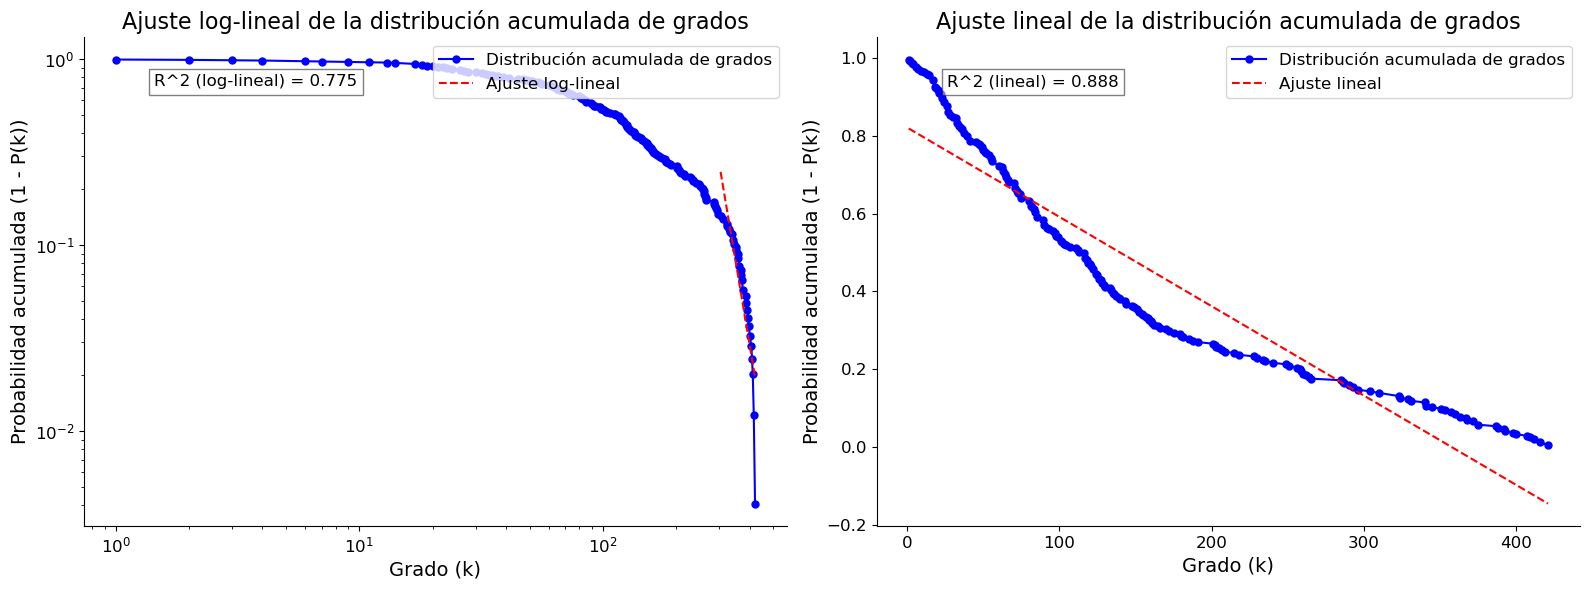

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def power_law_fit(graph, cutoff_value):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Eliminar los valores cero y negativos antes de calcular los logaritmos
    valid_indices = p_cumulative > 0
    log_k_values = np.log(k_values[valid_indices])
    log_p_cumulative = np.log(p_cumulative[valid_indices])

    # Obtener solo los datos después del valor de corte
    cutoff_index = np.argmax(k_values > cutoff_value)
    log_k_values = log_k_values[cutoff_index:]
    log_p_cumulative = log_p_cumulative[cutoff_index:]

    # Ajuste lineal en escala log-lineal
    fit_coefficients_log_linear = np.polyfit(log_k_values, log_p_cumulative, deg=1)

    # Calcular el R^2 del ajuste log-lineal
    fit_line_log_linear = np.polyval(fit_coefficients_log_linear, log_k_values)
    residuals_log_linear = log_p_cumulative - fit_line_log_linear
    ss_res_log_linear = np.sum(residuals_log_linear**2)
    ss_tot_log_linear = np.sum((log_p_cumulative - np.mean(log_p_cumulative))**2)
    r_squared_log_linear = 1 - (ss_res_log_linear / ss_tot_log_linear)

    # Ajuste lineal en escala lineal
    fit_coefficients_linear = np.polyfit(k_values[valid_indices], p_cumulative[valid_indices], deg=1)

    # Calcular el R^2 del ajuste lineal
    fit_line_linear = np.polyval(fit_coefficients_linear, k_values[valid_indices])
    residuals_linear = p_cumulative[valid_indices] - fit_line_linear
    ss_res_linear = np.sum(residuals_linear**2)
    ss_tot_linear = np.sum((p_cumulative[valid_indices] - np.mean(p_cumulative[valid_indices]))**2)
    r_squared_linear = 1 - (ss_res_linear / ss_tot_linear)

    # Graficar la distribución acumulada de grados y los ajustes en subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfica en escala log-lineal
    axes[0].plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    axes[0].plot(np.exp(log_k_values), np.exp(fit_line_log_linear), "r--", label="Ajuste log-lineal")
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Grado (k)", fontsize=14)
    axes[0].set_ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    axes[0].set_title("Ajuste log-lineal de la distribución acumulada de grados", fontsize=16)
    axes[0].legend(loc="upper right", fontsize=12)
    axes[0].grid(False)

    # Gráfica en escala lineal
    axes[1].plot(k_values[valid_indices], p_cumulative[valid_indices], "bo-", label="Distribución acumulada de grados", markersize=5)
    axes[1].plot(k_values[valid_indices], fit_line_linear, "r--", label="Ajuste lineal")
    axes[1].set_xlabel("Grado (k)", fontsize=14)
    axes[1].set_ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    axes[1].set_title("Ajuste lineal de la distribución acumulada de grados", fontsize=16)
    axes[1].legend(loc="upper right", fontsize=12)
    axes[1].grid(False)

    # Ajustes estéticos para ambos subplots
    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=10)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    # Imprimir el R^2 en ambas gráficas
    axes[0].text(0.1, 0.9, f'R^2 (log-lineal) = {r_squared_log_linear:.3f}', transform=axes[0].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    axes[1].text(0.1, 0.9, f'R^2 (lineal) = {r_squared_linear:.3f}', transform=axes[1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar la distribución acumulada de grados con los ajustes log-lineal y lineal del primer grafo en la lista
power_law_fit(grafos[0], cutoff_value=300)


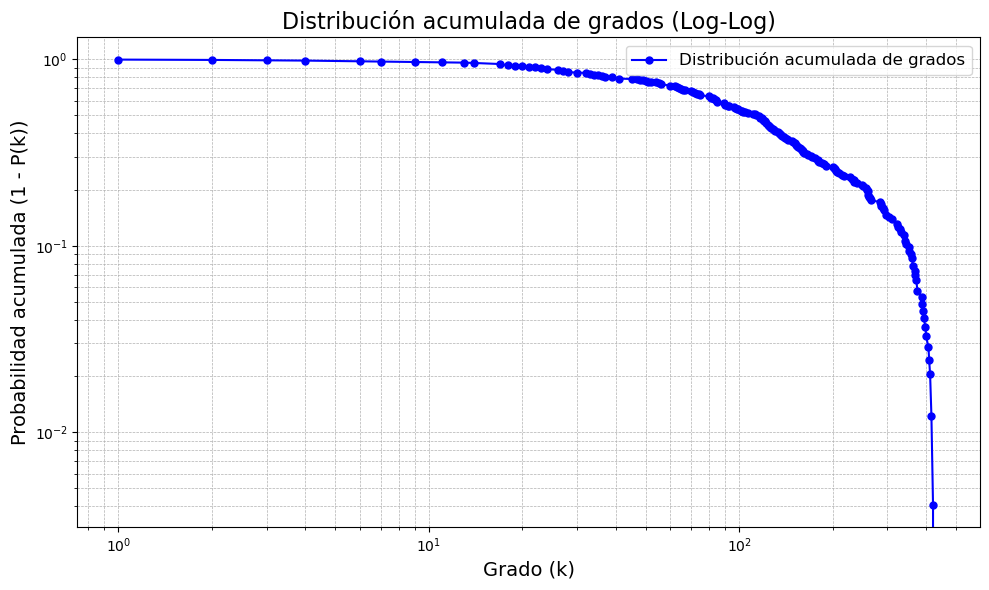

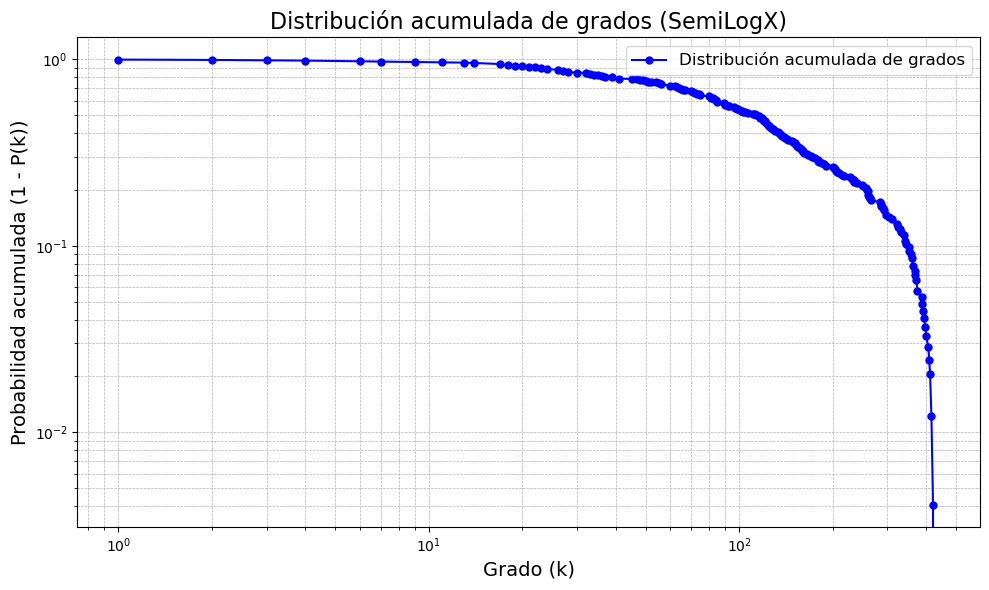

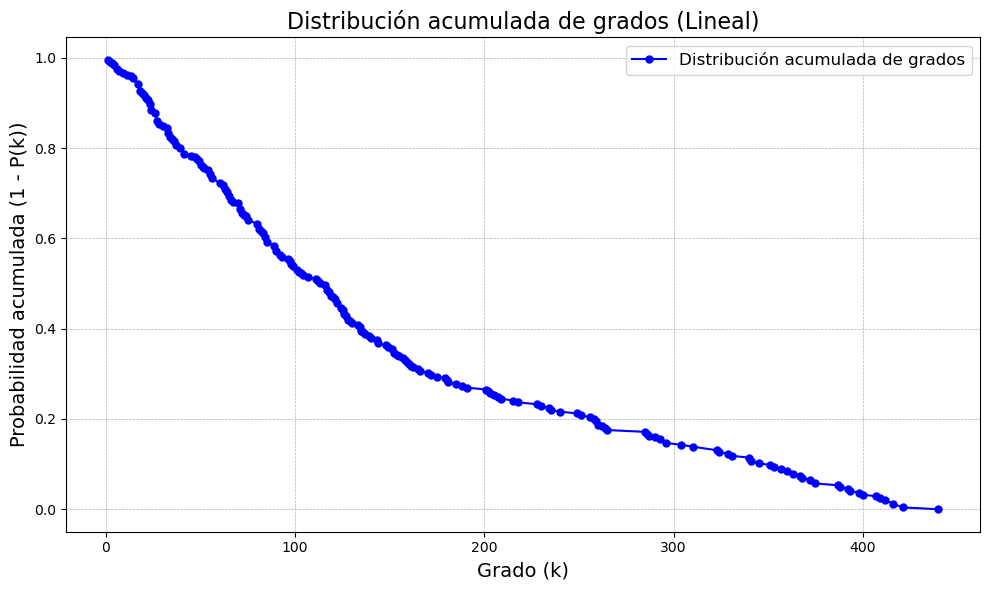

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Graficar en escala log-log
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (Log-Log)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Graficar en escala semilogx
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.semilogx()
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (SemiLogX)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Graficar en escala lineal
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (Lineal)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar las tres distribuciones acumuladas de grados del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


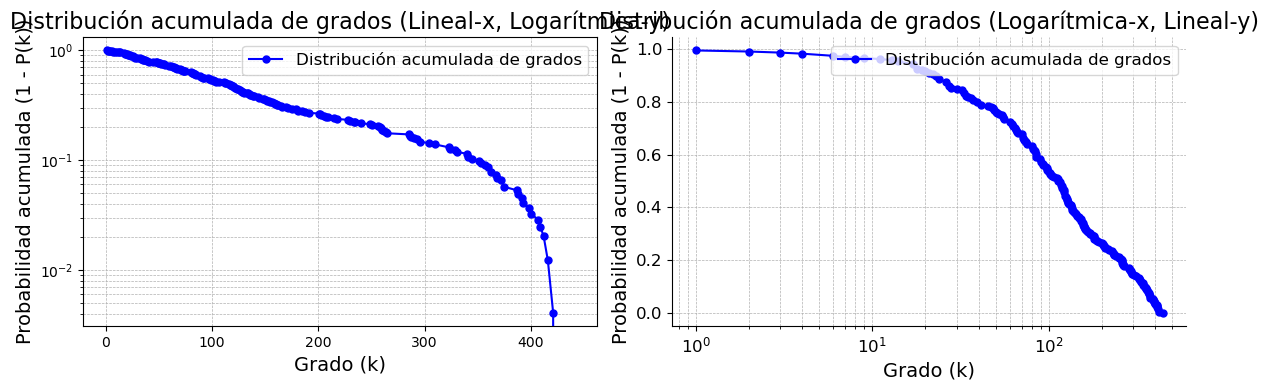

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Graficar en escala log-log
    plt.figure(figsize=(12, 4))

    # Gráfica 1: Escala lineal-x y logarítmica-y
    plt.subplot(1, 2, 1)
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("linear")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (Lineal-x, Logarítmica-y)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Gráfica 2: Escala logarítmica-x y lineal-y
    plt.subplot(1, 2, 2)
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("log")
    plt.yscale("linear")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (Logarítmica-x, Lineal-y)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar las tres distribuciones acumuladas de grados del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])


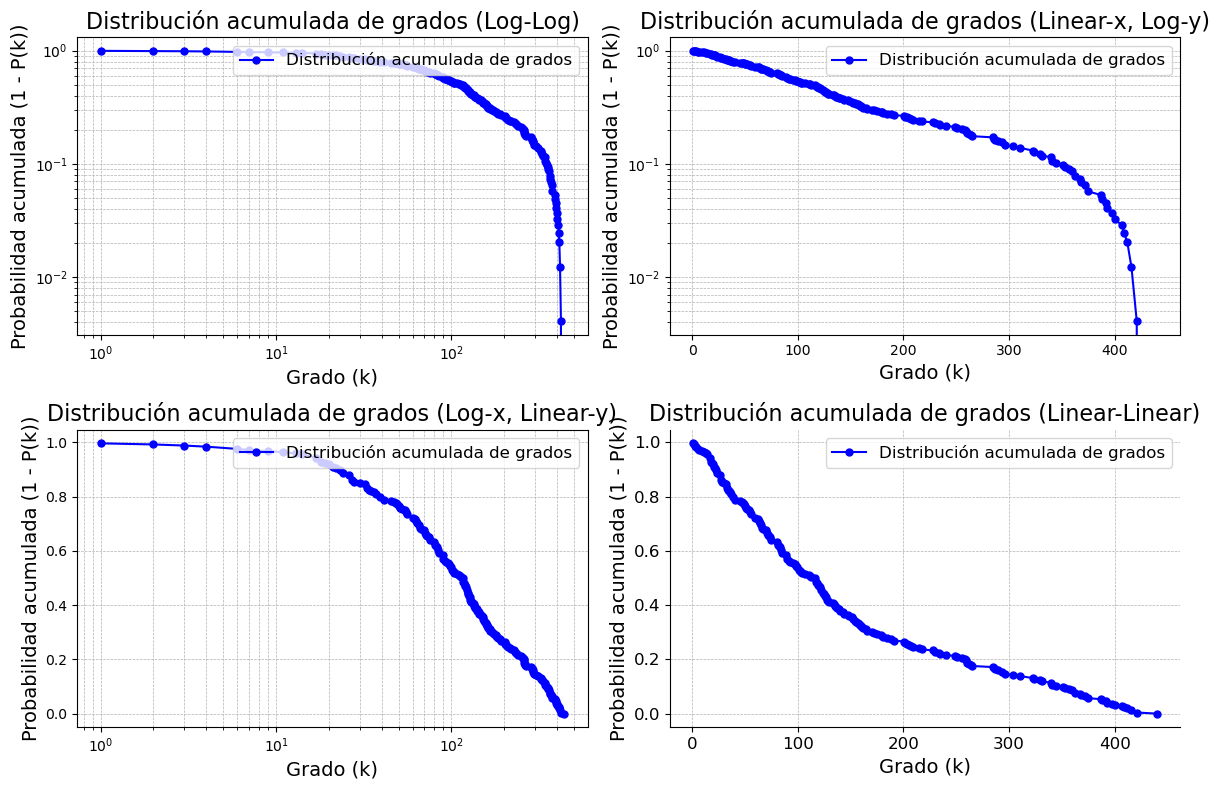

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_degree_distribution_for_graph(graph):
    # Obtener los grados de los nodos en el grafo
    degrees = list(dict(graph.degree()).values())

    # Calcular la distribución de grado p(k)
    k_values, p_k = np.unique(degrees, return_counts=True)
    p_k = p_k / len(degrees)

    # Ordenar los valores de grado y probabilidad acumulada en orden ascendente
    sorted_indices = np.argsort(k_values)
    k_values = k_values[sorted_indices]
    p_k = p_k[sorted_indices]

    # Calcular la distribución acumulada de grados
    p_cumulative = np.cumsum(p_k)

    # Convertir la CDF en una distribución decreciente
    p_cumulative = 1 - p_cumulative

    # Graficar en escala log-log
    plt.figure(figsize=(12, 8))

    # Gráfica 1: Escala log-log
    plt.subplot(2, 2, 1)
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (Log-Log)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Gráfica 2: Escala lineal-x y logarítmica-y
    plt.subplot(2, 2, 2)
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("linear")
    plt.yscale("log")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (Linear-x, Log-y)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Gráfica 3: Escala logarítmica-x y lineal-y
    plt.subplot(2, 2, 3)
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("log")
    plt.yscale("linear")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (Log-x, Linear-y)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Gráfica 4: Escala lineal-lineal
    plt.subplot(2, 2, 4)
    plt.plot(k_values, p_cumulative, "bo-", label="Distribución acumulada de grados", markersize=5)
    plt.xscale("linear")
    plt.yscale("linear")
    plt.xlabel("Grado (k)", fontsize=14)
    plt.ylabel("Probabilidad acumulada (1 - P(k))", fontsize=14)
    plt.title("Distribución acumulada de grados (Linear-Linear)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Ajustes estéticos
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()

    plt.show()

# Suponiendo que grafos es la lista de grafos
# grafos = crear_grafos(datasets)

# Graficar las cuatro distribuciones acumuladas de grados del primer grafo en la lista
plot_cumulative_degree_distribution_for_graph(grafos[0])
